In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from fuzzylab import *
from skfuzzy import control as ctrl 
import skfuzzy as fuzz
from numpy.linalg import multi_dot
from scipy.integrate import odeint

In [2]:
T = .1
V = .5
L = 2.5
t = np.arange(0, 400, T)

In [3]:
class FuzzySystem():
    def __init__(self):
        
        # Create x1e x1ree fuzzy variables - two inputs (x1,x2) and one control input (d)
#         self.theta = ctrl.Antecedent(np.arange(0,1, T),'theta')
#         self.y = ctrl.Antecedent(np.arange(0,1, T),'y')
#         self.u = ctrl.Consequent(np.arange(0,1, T),'u')
        self.theta = ctrl.Antecedent(np.arange(-np.pi, np.pi, 0.001),'theta')
        self.y = ctrl.Antecedent(np.arange(-100, 100, 0.001),'y')
        self.u = ctrl.Consequent(np.arange(-np.pi/6, np.pi/6, 0.001),'u')
        
        #Create fuzzy set for theta
        self.theta['negbig'] = fuzz.trapmf(self.theta.universe, [-np.pi, -np.pi, -3*np.pi/4, -np.pi/2]) 
        self.theta['goingdown'] = fuzz.trimf(self.theta.universe, [-3*np.pi/4, -np.pi/2, -np.pi/4])
        self.theta['neg'] = fuzz.trimf(self.theta.universe, [-np.pi/2, -np.pi/4, 0])
        self.theta['zero'] = fuzz.trimf(self.theta.universe, [-np.pi/12, 0, np.pi/12])
        self.theta['pos'] = fuzz.trimf(self.theta.universe, [0, np.pi/4, np.pi/2])
        self.theta['goingup'] = fuzz.trimf(self.theta.universe, [np.pi/4, np.pi/2, 3*np.pi/4])
        self.theta['posbig'] = fuzz.trapmf(self.theta.universe, [np.pi/2, 3*np.pi/4, np.pi, np.pi])
        
        #Create fuzzy set for y
        self.y['negbig'] = fuzz.trapmf(self.y.universe, [-100, -100, -50, -25])
        self.y['neg'] = fuzz.trimf(self.y.universe, [-50, -25, 0])
        self.y['zero'] =fuzz.trimf(self.y.universe, [-25, 0, 25])
        self.y['pos'] = fuzz.trimf(self.y.universe, [0 , 25 , 50])
        self.y['posbig'] = fuzz.trapmf(self.y.universe, [25, 50, 100, 100])

        #Create fuzzx2 set for control input u
        self.u['turnneg'] = fuzz.trapmf(self.u.universe, [-np.pi/6, -np.pi/6, -np.pi/12, 0])
        self.u['turnzero'] = fuzz.trimf(self.u.universe, [-np.pi/18, 0, np.pi/18])
        self.u['turnpos'] =fuzz.trapmf(self.u.universe, [0, np.pi/12, np.pi/6, np.pi/6])
        
        #Create fuzzx2 rules
        #General Rules:
        #να δοκμασω να αφησω να παρκαρει και στις 180 μοιρες
        
        self.rule0 = ctrl.Rule(antecedent=(self.theta['negbig']),
                                     consequent=self.u['turnpos'], label='rule turnpos 1')
        
        self.rule1= ctrl.Rule(antecedent=(self.theta['posbig']),
                                     consequent=self.u['turnneg'], label='rule turnneg 1')
        #theta == goingdown
        self.rule2 = ctrl.Rule(antecedent=(self.theta['goingdown'] & (self.y['pos'] | self.y['posbig'])),
                                     consequent=self.u['turnzero'], label='rule trunzero 1')
        
        self.rule3 = ctrl.Rule(antecedent=((self.theta['neg'] | self.theta['goingdown']) & (self.y['zero'] | self.y['neg'] | self.y['negbig'])),
                                     consequent=self.u['turnpos'], label='rule turnpos 2')
        
        #theta == goingup
        
        self.rule4 = ctrl.Rule(antecedent=(self.theta['goingup'] & (self.y['neg'] | self.y['negbig'])),
                                     consequent=self.u['turnzero'], label='rule turnzero 2')
        
        self.rule5 = ctrl.Rule(antecedent=((self.theta['pos'] | self.theta['goingup']) & (self.y['zero'] | self.y['pos'] | self.y['posbig'])),
                                     consequent=self.u['turnneg'], label='rule turnneg 2')
        
        #try to converge faster
        self.rule6 = ctrl.Rule(antecedent=(self.theta['neg'] & (self.y['pos'] | self.y['posbig'])),
                                     consequent=self.u['turnneg'], label='rule turnneg 3')
        
        self.rule7 = ctrl.Rule(antecedent=(self.theta['pos'] & (self.y['neg'] | self.y['negbig'])),
                                     consequent=self.u['turnpos'], label='rule turnpos 3')
        
        self.rule8 = ctrl.Rule(antecedent=(self.theta['zero'] & self.y['zero']),
                                     consequent=self.u['turnzero'], label='rule trunzero 3')
        
        self.rule9 = ctrl.Rule(antecedent=(self.theta['zero'] & (self.y['neg'] | self.y['negbig'])),
                                     consequent=self.u['turnpos'], label='rule turnpos 4')
        
        self.rule10 = ctrl.Rule(antecedent=(self.theta['zero'] & (self.y['pos'] | self.y['posbig'])),
                                     consequent=self.u['turnneg'], label='rule turnneg 4')

        self.system = ctrl.ControlSystem(rules=[self.rule0, self.rule1, self.rule2, self.rule3, self.rule4, self.rule5, self.rule6, self.rule7, self.rule8, self.rule9, self.rule10])
        self.tipping = ctrl.ControlSystemSimulation(self.system)
        
        #Plot fuzzy sets
    def plot(self):
        
        plt.subplots(3,1,figsize=(15,10))
        
        plt.subplot(3,1,1)
        plt.title("Control Output theta")
        plt.plot(self.theta.universe,fuzz.trapmf(self.theta.universe, [-np.pi, -np.pi, -5*np.pi/9, -np.pi/2]),label="negbig")
        plt.plot(self.theta.universe,fuzz.trimf(self.theta.universe, [-3*np.pi/4, -np.pi/2, -np.pi/4]),label="goingdown")
        plt.plot(self.theta.universe,fuzz.trimf(self.theta.universe, [-np.pi/2, -np.pi/4, 0]),label="neg")
        plt.plot(self.theta.universe,fuzz.trimf(self.theta.universe, [-np.pi/12, 0, np.pi/12]),label="zero")
        plt.plot(self.theta.universe,fuzz.trimf(self.theta.universe, [0, np.pi/4, np.pi/2]),label="pos")
        plt.plot(self.theta.universe,fuzz.trimf(self.theta.universe, [np.pi/4, np.pi/2, 3*np.pi/4]),label="goingup")
        plt.plot(self.theta.universe,fuzz.trapmf(self.theta.universe, [np.pi/2, 5*np.pi/9, np.pi, np.pi]),label="posbig")
        plt.legend()

        plt.subplot(3,1,2)
        plt.title("Control Output y")
        plt.plot(self.y.universe,fuzz.trapmf(self.y.universe, [-100, -100, -50, -25]),label="negbig")
        plt.plot(self.y.universe,fuzz.trimf(self.y.universe, [-50, -25, 0]),label="neg")
        plt.plot(self.y.universe, fuzz.trimf(self.y.universe, [-25, 0, 25]),label="zero")
        plt.plot(self.y.universe,fuzz.trimf(self.y.universe, [0 , 25 , 50]),label="pos")
        plt.plot(self.y.universe,fuzz.trapmf(self.y.universe, [25, 50, 100, 100]),label="posbig")
        plt.legend()
     
        plt.subplot(3,1,3)
        plt.title("Control Input u")
        plt.plot(self.u.universe,fuzz.trapmf(self.u.universe, [-np.pi/6, -np.pi/6, -np.pi/12, 0]),label="turnneg")
        plt.plot(self.u.universe,fuzz.trimf(self.u.universe, [-np.pi/18, 0, np.pi/18]),label="turnzero")
        plt.plot(self.u.universe,fuzz.trapmf(self.u.universe, [0, np.pi/12, np.pi/6, np.pi/6]),label="turnpos")
        plt.legend()
        plt.show()

    def get_result(self, theta, y):
        self.tipping.input['theta'] = theta
        self.tipping.input['y'] = y
        self.tipping.compute()
        res=self.tipping.output['u']
        return (res)
            #https://www.researchgate.net/publication/270501924_Fuzzy_Expert_System_for_Tropical_Infectious_Disease_by_Certainty_Factor
        

In [4]:
fs = FuzzySystem()

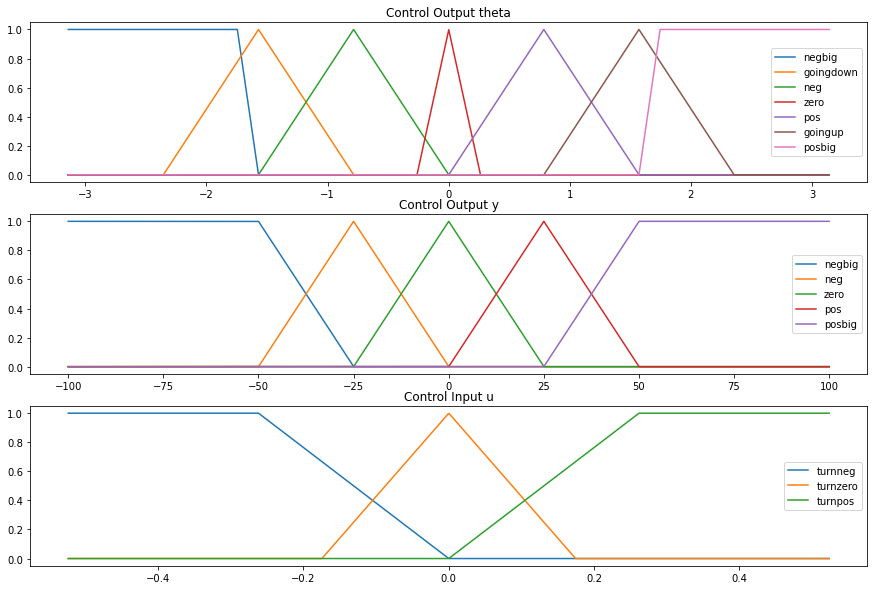

In [5]:
fs.plot()

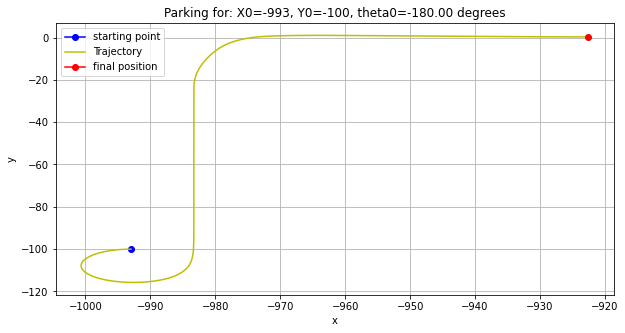

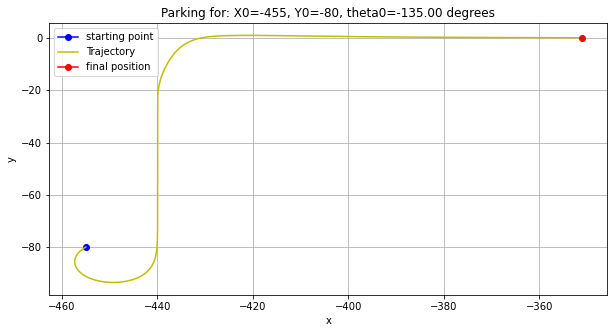

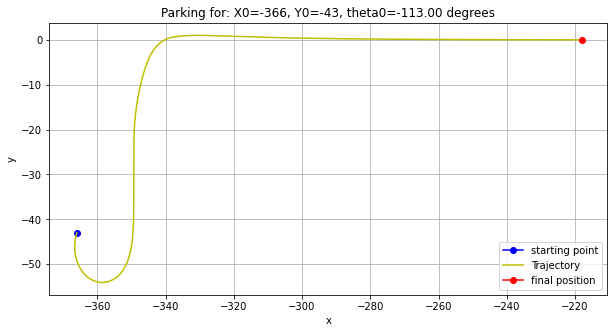

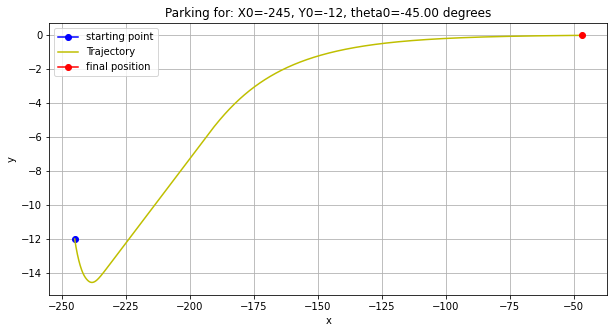

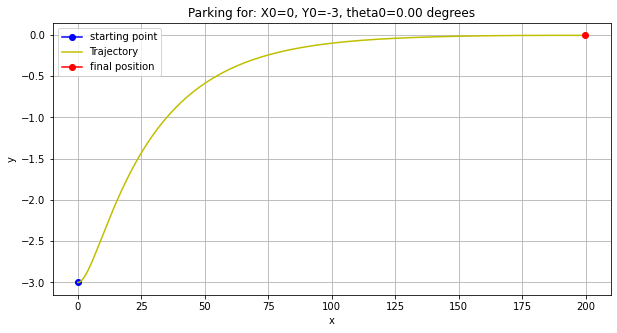

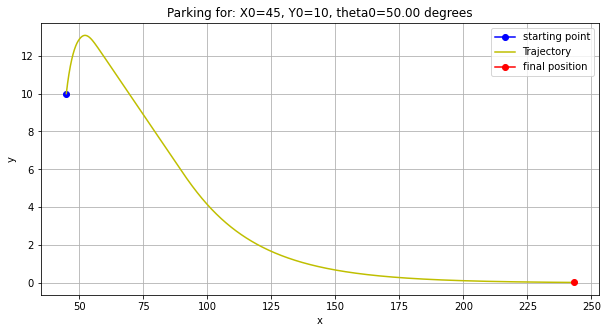

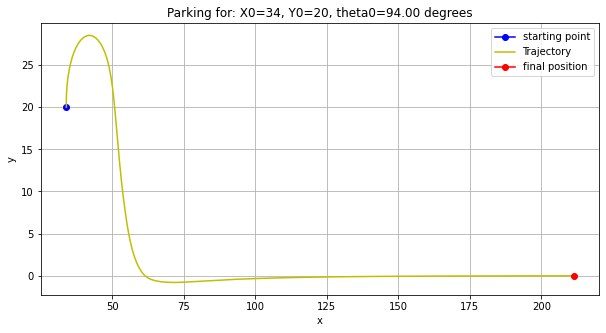

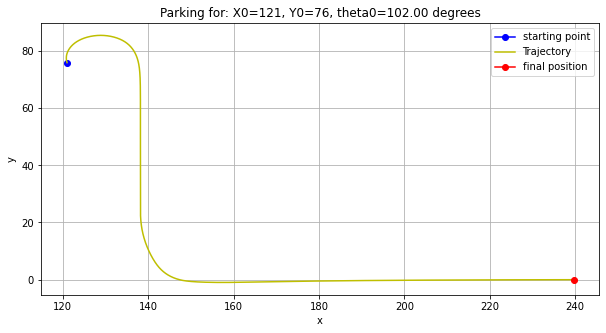

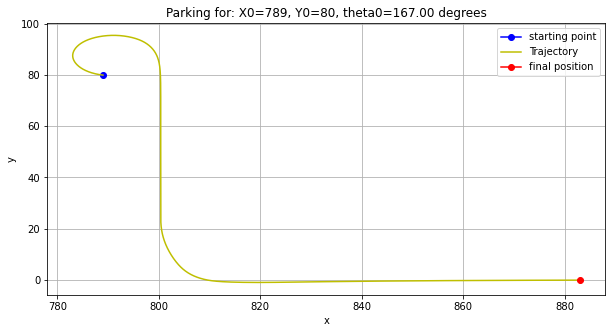

In [ ]:
theta0 = [-np.pi, -3*np.pi/4, -113*np.pi/180, -np.pi/4, 0, 5*np.pi/18, 47*np.pi/90, 17*np.pi/30, 167*np.pi/180, np.pi]
y0 = [-100, -80, -43, -12, -3, 10, 20, 76, 80, 100]
x0 = [-993, -455, -366, -245, 0, 45, 34, 121, 789, 1000]
for i in range(len(theta0)):
    z0 = [theta0[i], y0[i], x0[i]] 
    u = np.zeros(len(t))
    u[0] = fs.get_result(theta0[i], y0[i])
    theta = np.zeros(len(t))
    theta[0] = theta0[i]
    y = np.zeros(len(t))
    y[0] = y0[i]
    x = np.zeros(len(t))
    x[0] = x0[i]
    plt.figure(figsize=(10,5))
    plt.title(f'Parking for: X0={x0[i]}, Y0={y0[i]}, theta0={"%.2f" % (theta0[i]*180/np.pi)} degrees')
    plt.plot(x0[i], y0[i], marker="o",color="blue", label="starting point")
    for k in range(1, len(t)):
        
        dthetadt = T*V*np.tan(u[k-1])/L
        dxdt = T*V*np.cos(theta[k-1])
        dydt = T*V*np.sin(theta[k-1])

        theta[k] = theta[k-1] + dthetadt
        if(theta[k]<-np.pi):
            theta[k]=theta[k]+2*np.pi
        if(theta[k]>np.pi):
            theta[k]=theta[k]-2*np.pi
        y[k] = y[k-1] + dydt
        x[k] = x[k-1] + dxdt
        u[k] = fs.get_result(theta[k], y[k])
        
    
    plt.plot(x, y, 'y', label='Trajectory')
    plt.plot(x[len(x)-1],y[len(y)-1],marker="o",color="red" ,label="final position")
    plt.legend(loc='best')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.show()
